In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pyvi.ViTokenizer import tokenize
import os
from sentence_transformers import SentenceTransformer

d:\tailieuki5\DPL302m\Vietnamese_Law_Assistant_Chatbot\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load biến môi trường từ file .env
load_dotenv(".env")
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

In [3]:
# Tạo chuỗi kết nối
connection_string = f"mysql+pymysql://{user}:{password}@{host}:{port}/{db_name}?charset=utf8mb4"

In [4]:
# Tạo engine
engine = create_engine(connection_string)

In [5]:
# Query lấy dữ liệu và lưu vào dataframe
query = "select mapc, noidung, pd_dieu.ten, vbqppl" \
"        from pd_dieu join pd_chude on pd_dieu.chude_id = pd_chude.id" \
"        where pd_chude.stt = '39';"
df = pd.read_sql(query, engine)

In [6]:
df.head()

,mapc,noidung,ten,vbqppl
0,39001001000000000000,Chứng minh nhân dân quy định tại Nghị định này...,Điều 39.1.NĐ.1. Chứng minh nhân dân,Điều 1 Nghị định số 05/1999/NĐ-CP Về chứng min...
1,39001002000000000000,"Chứng minh nhân dân hình chữ nhật dài 85,6 mm,...",Điều 39.1.NĐ.2.,"Điều 2 Nghị định số 05/1999/NĐ-CP, có hiệu lực..."
2,39001003000000000000,"1. Công dân Việt Nam từ đủ 14 tuổi trở lên, đa...",Điều 39.1.NĐ.3. Đối tượng được cấp Chứng minh ...,"Điều 3 Nghị định số 05/1999/NĐ-CP, có hiệu lực..."
3,3900100300000000000000801959700040000100,Điều 3 Nghị định số 05/1999/NĐ-CP quy định đối...,Điều 39.1.TT.1.1. Đối tượng được cấp CMND,Điều 1 Thông tư số 04/1999/TT-BCA(C13) Hướng d...
4,3900100300000000000000801959700040000300,1. Công dân được sử dụng CMND của mình làm giấ...,Điều 39.1.TT.1.3. Quyền và trách nhiệm công dân,"Điều 3 Thông tư số 04/1999/TT-BCA(C13), có hiệ..."


In [7]:
# Tải model embedding để tính toán lượng token
model = SentenceTransformer('dangvantuan/vietnamese-embedding')
tokenizer = model.tokenizer

In [8]:
# Tính số lượng token của mỗi điều (có sử dụng pyvi để tokenize)
df["len_noidung"] = df["noidung"].apply(lambda x: len(tokenizer.encode(tokenize(x))))

Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors


In [35]:
print(tokenize('?. 1123 Hà Tĩnh - điều 301 ?'))

? . 1123 Hà_Tĩnh - điều 301 ?


In [9]:
df['len_noidung'].describe()

count    1640.000000
mean      224.131707
std       252.476903
min         2.000000
25%        74.000000
50%       149.000000
75%       284.000000
max      3090.000000
Name: len_noidung, dtype: float64

$\implies$ Trung bình các điều dài khoảng 224 tokens, thấp nhất là 2 tokens và cao nhất là 3090 tokens

In [10]:
# Kiểm tra nội dung 1 số điều có độ dài ngắn
short_contents = [nd for nd in df[df['len_noidung']<10]['noidung']]
short_contents

['(Bị bãi bỏ)\n', '(Bị bãi bỏ)\n', '', '', '', '', '', '', '', '']

$\implies$ 1 số điều có độ dài ngắn và không mang ý nghĩa nên cần loại bỏ

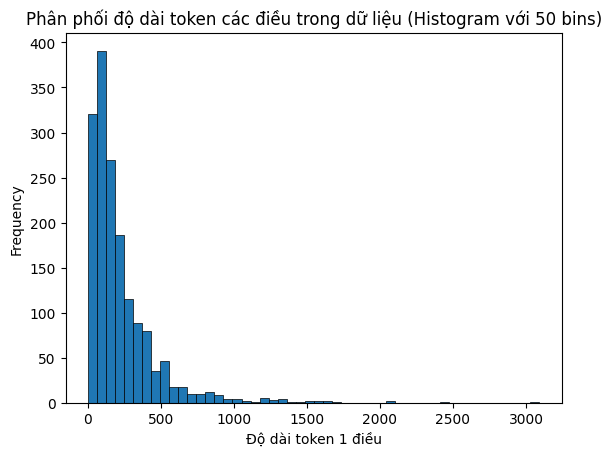

Có 138/1640 điều có độ dài token > 512 (cần chunking)


In [11]:
# Visualization
plt.hist(df['len_noidung'], bins=50, edgecolor='black', linewidth=0.5)
plt.title('Phân phối độ dài token các điều trong dữ liệu (Histogram với 50 bins)')
plt.xlabel('Độ dài token 1 điều')
plt.ylabel('Frequency')
plt.show()
print(f"Có {(df['len_noidung'] > 512).sum()}/{len(df)} điều có độ dài token > 512 (cần chunking)")